# CSC345: Object Recognition Coursework
This notebook details two methods for performing object recognition on the provided subset of the Cifar-100 image dataset.

The first method uses an SVM trained on HOGs generated from the image dataset.<br>
The second method uses a CNN trained on a scaled version of the dataset. 

# SVM Implementation of Object Recognition on a Subset of the CIFAR-100 Dataset

For this implementation, we are using a Support Vector Machine to classify the images in the dataset. 

This model is trained using Histograms of Oriented Gradients that are generated from the given data files. 

This section contains two runs, the first using the coarse labels for the data, and the second using the fine labels.

In [40]:
import numpy as np
import skimage.feature

First, we need to load the training data files. 
Here, BASE_PATH points to the folder containing the data files. 

In [41]:
BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/cw_data/'

images = np.load(BASE_PATH + '/trnImage.npy')
label_fine = np.load(BASE_PATH + '/trnLabel_fine.npy')
label_coarse = np.load(BASE_PATH + '/trnLabel_coarse.npy')

This cell contains a configurable limiter (currently disabled), for training the SVM using less than the entire dataset, to speed up incremental testing.

In [42]:
LIMITER = 10000

# images = images[:,:,:,:LIMITER]
# label_coarse = label_coarse[:LIMITER]
# label_fine = label_fine[:LIMITER]

To use the provided data with an SVM, it needs some initial processing to generate a Histogram of Oriented Gradients for each image in the data set.

This function takes a dataset, in the format provided for the coursework, and returns an array of Histograms, one for each image provided.

In [43]:
def gen_hogs(dataset):
  ppc = 4
  hog_features = []
  for image_num in range(dataset.shape[3]):
    image = dataset[:, :, :, image_num]
    hog_features.append(skimage.feature.hog(image, pixels_per_cell=(6,6), cells_per_block=(2,2), visualize=False))
    if image_num % 1000 == 0:
      # Prints the current image number every 1000 images to monitor progress
      print(image_num)
  return hog_features

Now that our helper function is defined, we can pass the training data into it to generate histograms for modeling. 

In [44]:
features = gen_hogs(images)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000


We take the histogram array generated, and convert it to an numpy array for easier processing. 

In [45]:
features_array = np.array(features)
print(features_array.shape)

(50000, 576)


## Coarse Labels Run

Now we can train an SVM on the HOGs from the training data, first using the coarse label set. 

In [46]:
from sklearn import svm

svm_coarse = svm.SVC()

x_train = features_array

svm_coarse.fit(x_train, label_coarse)

SVC()

For evaluating the model, we first need to load the test data and generate HOGs for it using the same helper function defined earlier. 

In [47]:
test_images = np.load(BASE_PATH + '/tstImage.npy')
test_label_fine = np.load(BASE_PATH + '/tstLabel_fine.npy')
test_label_coarse = np.load(BASE_PATH + '/tstLabel_coarse.npy')

In [48]:
x_test = np.array(gen_hogs(test_images))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


Then, we can run predictions on the model using the prepared test data, and evaluate the accuracy of the classification. 

In [49]:
y_predict_coarse = svm_coarse.predict(x_test)

In [50]:
from sklearn.metrics import accuracy_score, classification_report

print("Accuracy: "+str(accuracy_score(test_label_coarse, y_predict_coarse)))
print(classification_report(test_label_coarse, y_predict_coarse))

Accuracy: 0.3939
              precision    recall  f1-score   support

           0       0.28      0.30      0.29       500
           1       0.36      0.38      0.37       500
           2       0.31      0.35      0.33       500
           3       0.57      0.59      0.58       500
           4       0.47      0.39      0.43       500
           5       0.56      0.43      0.49       500
           6       0.57      0.64      0.60       500
           7       0.33      0.37      0.35       500
           8       0.26      0.35      0.30       500
           9       0.45      0.53      0.48       500
          10       0.59      0.50      0.54       500
          11       0.28      0.29      0.28       500
          12       0.22      0.20      0.21       500
          13       0.30      0.22      0.25       500
          14       0.41      0.38      0.40       500
          15       0.25      0.24      0.24       500
          16       0.26      0.22      0.24       500
          

## Fine Labels Run

Now we can train a new SVM using the training data and the fine labels. 

In [51]:
svm_fine = svm.SVC()
svm_fine.fit(x_train, label_fine)

SVC()

Then we evaluate the model performace using the fine testing labels.

In [52]:
y_predict_fine = svm_fine.predict(x_test)

In [53]:
print("Accuracy: "+str(accuracy_score(test_label_fine, y_predict_fine)))
print(classification_report(test_label_fine, y_predict_fine))

Accuracy: 0.282
              precision    recall  f1-score   support

           0       0.64      0.54      0.58       100
           1       0.29      0.31      0.30       100
           2       0.10      0.04      0.06       100
           3       0.13      0.10      0.11       100
           4       0.14      0.10      0.11       100
           5       0.40      0.41      0.41       100
           6       0.10      0.18      0.13       100
           7       0.16      0.16      0.16       100
           8       0.50      0.47      0.48       100
           9       0.53      0.57      0.55       100
          10       0.35      0.38      0.37       100
          11       0.24      0.14      0.18       100
          12       0.28      0.31      0.29       100
          13       0.25      0.26      0.25       100
          14       0.19      0.30      0.23       100
          15       0.28      0.22      0.25       100
          16       0.45      0.41      0.43       100
          1

# CNN Implementation of Object Recognition on a Subset of the CIFAR-100 Dataset

For this implementation, we are using a Convolutional Neural Network to classify images from the dataset.

This section contains a single CNN network structure, which is trained and tested, first on the coarse labels, then on the fine labels.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.feature

First, we need to load the training data files. Here, BASE_PATH points to the folder containing the data files.

In [14]:
BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/cw_data/'

trn_images = np.load(BASE_PATH+'/trnImage.npy')
trn_label_fine = np.load(BASE_PATH+'/trnLabel_fine.npy')
trn_label_coarse = np.load(BASE_PATH+'/trnLabel_coarse.npy')

print(f'Images Shape: {trn_images.shape}')
print(f'Images Fine Labels Shape: {trn_label_fine.shape}')
print(f'Images Coarse Labels Shape: {trn_label_coarse.shape}')

Images Shape: (32, 32, 3, 50000)
Images Fine Labels Shape: (50000,)
Images Coarse Labels Shape: (50000,)


The data format provided is not the standard expected for Tensorflow Keras models, so we need to transpose so that the sample number is the first dimension.

In [15]:
print(trn_images.shape)
trn_images = np.transpose(trn_images, (3,0,1,2))
print(trn_images.shape)

(32, 32, 3, 50000)
(50000, 32, 32, 3)


Now that the data is loaded and processed, we define the properties for our CNN and compile it. 

In [16]:
import tensorflow as tf

model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=(32,32,3), padding="same"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu',padding="same"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(256, kernel_size=(3,3), activation='relu',padding="same"))
model.add(tf.keras.layers.SpatialDropout2D(0.2))
model.add(tf.keras.layers.AveragePooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu',padding="same"))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(100))

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

## Coarse Labels Run

Then we can fit our prepared training data to the compiled model, using an 80:20 training:validation split. 

In [17]:
x_train = trn_images.astype("float32")

history = model.fit(x_train, trn_label_coarse, batch_size=128, epochs=10, validation_split=0.2, verbose=1)

Epoch 1/10
313/313 [==============================] - 10s 31ms/step - loss: 2.9717 - accuracy: 0.1282 - val_loss: 2.4768 - val_accuracy: 0.2367
Epoch 2/10
313/313 [==============================] - 10s 30ms/step - loss: 2.4594 - accuracy: 0.2410 - val_loss: 2.2629 - val_accuracy: 0.3031
Epoch 3/10
313/313 [==============================] - 10s 31ms/step - loss: 2.2732 - accuracy: 0.2952 - val_loss: 2.0313 - val_accuracy: 0.3683
Epoch 4/10
313/313 [==============================] - 9s 30ms/step - loss: 2.1396 - accuracy: 0.3393 - val_loss: 1.9423 - val_accuracy: 0.3996
Epoch 5/10
313/313 [==============================] - 9s 30ms/step - loss: 2.0257 - accuracy: 0.3751 - val_loss: 1.8487 - val_accuracy: 0.4186
Epoch 6/10
313/313 [==============================] - 9s 30ms/step - loss: 1.9197 - accuracy: 0.4048 - val_loss: 1.7469 - val_accuracy: 0.4536
Epoch 7/10
313/313 [==============================] - 9s 30ms/step - loss: 1.8070 - accuracy: 0.4382 - val_loss: 1.6711 - val_accuracy: 0.4

Graphs of the Model's performance during training:

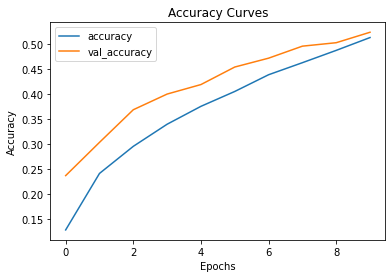

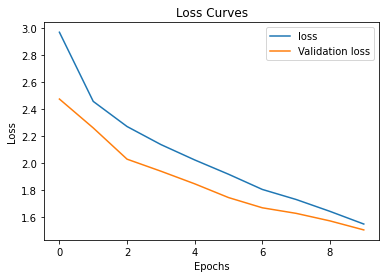

In [18]:
plt.figure()
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title("Accuracy Curves")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title("Loss Curves")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

To test our model, we can now load and prepare the test data, and run an evaluation function. 

In [19]:
tst_images = np.load(BASE_PATH+'/tstImage.npy')
tst_label_fine = np.load(BASE_PATH+'/tstLabel_fine.npy')
tst_label_coarse = np.load(BASE_PATH+'/tstLabel_coarse.npy')

tst_images = np.transpose(tst_images, (3,0,1,2))
tst_images = tst_images.astype("float32")

model.evaluate(tst_images, tst_label_coarse, verbose=1)

313/313 [==============================] - 3s 8ms/step - loss: 1.5082 - accuracy: 0.5274


[1.5082396268844604, 0.527400016784668]

In [20]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

## Fine Labels Run

In [21]:
history_fine = model.fit(x_train, trn_label_fine, batch_size=128, epochs=10, validation_split=0.2, verbose=1)

Epoch 1/10
313/313 [==============================] - 10s 31ms/step - loss: 4.7339 - accuracy: 0.0110 - val_loss: 4.5938 - val_accuracy: 0.0130
Epoch 2/10
313/313 [==============================] - 10s 32ms/step - loss: 4.5582 - accuracy: 0.0142 - val_loss: 4.3941 - val_accuracy: 0.0316
Epoch 3/10
313/313 [==============================] - 11s 35ms/step - loss: 4.4082 - accuracy: 0.0235 - val_loss: 4.2153 - val_accuracy: 0.0599
Epoch 4/10
313/313 [==============================] - 10s 32ms/step - loss: 4.2821 - accuracy: 0.0294 - val_loss: 4.0178 - val_accuracy: 0.0738
Epoch 5/10
313/313 [==============================] - 11s 35ms/step - loss: 4.0117 - accuracy: 0.0644 - val_loss: 3.4245 - val_accuracy: 0.1931
Epoch 6/10
313/313 [==============================] - 11s 34ms/step - loss: 3.4698 - accuracy: 0.1511 - val_loss: 2.9432 - val_accuracy: 0.2763
Epoch 7/10
313/313 [==============================] - 9s 29ms/step - loss: 3.0802 - accuracy: 0.2208 - val_loss: 2.7259 - val_accuracy: 

Graphs of the Model's performance during training:

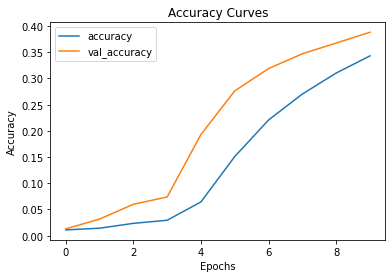

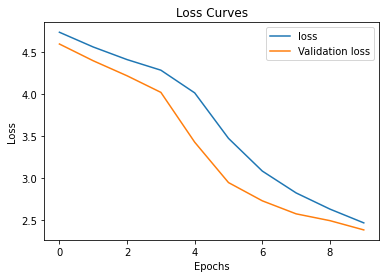

In [22]:
plt.figure()
plt.plot(history_fine.history['accuracy'], label='accuracy')
plt.plot(history_fine.history['val_accuracy'], label = 'val_accuracy')
plt.title("Accuracy Curves")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(history_fine.history['loss'], label='loss')
plt.plot(history_fine.history['val_loss'], label='Validation loss')
plt.title("Loss Curves")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Now time to evaluate the performance of the model on the fine labels.

In [23]:
model.evaluate(tst_images, tst_label_fine, verbose=1)

313/313 [==============================] - 3s 9ms/step - loss: 2.3531 - accuracy: 0.3938


[2.3530750274658203, 0.3937999904155731]